# Naive Bayes

## Librairies et dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

import re

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
dataset = load_dataset("yaful/DeepfakeTextDetect")
df = dataset["train"].to_pandas()
df.head()

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


## Training and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=69)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Fonctions de créations de tokens

In [8]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def byte_pair_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Création des modèles

In [9]:
classifiers = {}
for i in range(1,6):
    classifiers.update({f"{i}-gram": make_pipeline(CountVectorizer(ngram_range = (i,i)), MultinomialNB())})
classifiers

{'1-gram': Pipeline(steps=[('countvectorizer', CountVectorizer()),
                 ('multinomialnb', MultinomialNB())]),
 '2-gram': Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(2, 2))),
                 ('multinomialnb', MultinomialNB())]),
 '3-gram': Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(3, 3))),
                 ('multinomialnb', MultinomialNB())]),
 '4-gram': Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(4, 4))),
                 ('multinomialnb', MultinomialNB())]),
 '5-gram': Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(5, 5))),
                 ('multinomialnb', MultinomialNB())])}

## Entraînements, prédictions et matrices de confusion

Model: 1-gram
Features dimension: (255256, 303472)
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79     45082
           1       0.53      0.72      0.61     18733

    accuracy                           0.73     63815
   macro avg       0.70      0.73      0.70     63815
weighted avg       0.77      0.73      0.74     63815

Model: 2-gram
Features dimension: (255256, 7446478)
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     45082
           1       0.80      0.71      0.75     18733

    accuracy                           0.86     63815
   macro avg       0.84      0.82      0.83     63815
weighted avg       0.86      0.86      0.86     63815

Model: 3-gram
Features dimension: (255256, 24269662)
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92     45082
         

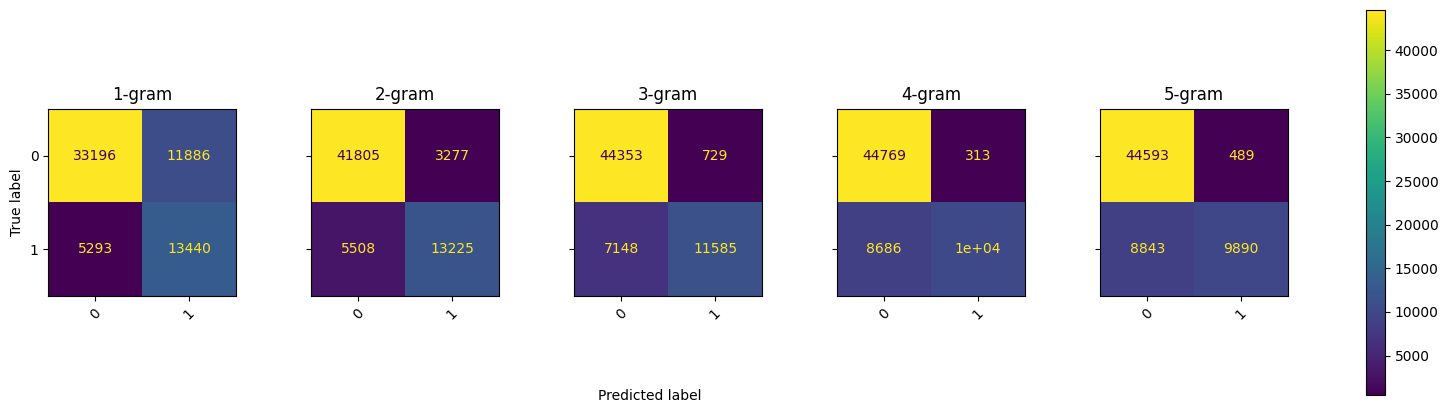

In [10]:
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    print("Model: " + key)
    y_pred = classifier.fit(X_train, y_train, multinomialnb__sample_weight=sample_weights).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Features dimension: {len(X_train), len(classifier[0].vocabulary_)}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=classifier.classes_)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0: 
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()